In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from scipy import ndimage as ndi
from scipy.signal import argrelextrema
from sklearn.model_selection import train_test_split, StratifiedKFold
import sklearn.ensemble as ensemble
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier
import sklearn.neighbors as neighbors
import sklearn.neural_network as nn
import sklearn.cluster as cluster
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD as TSVD
from tqdm import tqdm

In [2]:
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"

In [3]:
from os import getcwd, listdir
from os.path import isfile, join

In [4]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
#     values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [5]:
curr_path = getcwd()

### Feature organization

In [5]:
cases = ['TIFF files-3Days', 'TIFF files-7Days', 'LCMV_BMS_STAT1_CXCL10']

all_features = pd.DataFrame()

for case in cases:
    feature_path = join(curr_path, 'features', case)
    ins_tif_path = join('E:/OneDrive - Indiana University/jing research/diabetes/PDL MX1/channels', case)
    label_path = join('E:/OneDrive - Indiana University/jing research/diabetes/PDL MX1/results', case, 'expanded_labels')
    files_list = listdir(feature_path)

    for file in files_list:
        filename = file[:-19]
        c = file[-6:-4]

        # print(filename, c)

        feature = pd.read_csv(join(feature_path, file))
        ins_tif = np.array(imread(join(ins_tif_path, 'C3-' + filename + '.tif')))
        label = np.array(imread(join(label_path, filename + '_label.tif')))

        image_file_list = []
        ins_mean_list = []
        case_list = []
        days_list = []
        gene_list = []
        for cell in feature['cell']:
            cell_ins_mask = ins_tif[label==cell]

            image_file_list.append(filename)

            ins_mean = cell_ins_mask.mean()
            ins_mean_list.append(ins_mean)

            if('veh' in filename.lower()):
                case_list.append('veh')
            else:
                case_list.append('bms')

            if(case == 'TIFF files-3Days'):
                days_list.append(0)
                if('PDL1' in filename):
                    if(c == 'C1'):
                        gene_list.append('PDL1')
                    else:
                        gene_list.append('MX1')   
                else:
                    if(c == 'C1'):
                        gene_list.append('STAT1')
                    else:
                        gene_list.append('CXCL10')     

            if(case == 'TIFF files-7Days'):
                days_list.append(1)
                if('PDL1' in filename):
                    if(c == 'C1'):
                        gene_list.append('PDL1')
                    else:
                        gene_list.append('CXCL10')   
                else:
                    if(c == 'C1'):
                        gene_list.append('STAT1')
                    else:
                        gene_list.append('MX1')          

            if(case == 'LCMV_BMS_STAT1_CXCL10'):
                days_list.append(2)
                if('PDL1' in filename):
                    if(c == 'C1'):
                        gene_list.append('PDL1')
                    else:
                        gene_list.append('MX1')   
                else:
                    if(c == 'C1'):
                        gene_list.append('STAT1')
                    else:
                        gene_list.append('CXCL10')      

        feature['img_file'] = image_file_list
        feature['ins_mean'] = ins_mean_list
        feature['case'] = case_list
        feature['days'] = days_list
        feature['gene'] = gene_list

        all_features = pd.concat([all_features, feature])    
            


KeyboardInterrupt: 

In [ ]:
np.unique(all_features['days'].to_numpy(), return_counts=True)

(array([0, 1, 2], dtype=int64), array([ 8097, 18859,  8471], dtype=int64))

In [88]:
all_features.to_csv(join('E:/OneDrive - Indiana University/jing research/diabetes/PDL MX1/all features',
                         'STP_feautres_20240328.csv'), index=False)

### Feature analysis

In [6]:
all_features = pd.read_csv(join('E:/OneDrive - Indiana University/jing research/diabetes/PDL MX1/all features',
                         'STP_feautres_20240328.csv'))

In [7]:
hist_bms_3d = np.histogram(all_features[(all_features['days'] == 0) & (all_features['case'] == 'bms')]['ins_mean'], bins=200)
beta_thres_bms_3d = hist_bms_3d[1][argrelextrema(savitzky_golay(hist_bms_3d[0], 13, 2), np.less)[0][0]]

hist_veh_3d = np.histogram(all_features[(all_features['days'] == 0) & (all_features['case'] == 'veh')]['ins_mean'], bins=200)
beta_thres_veh_3d = hist_veh_3d[1][argrelextrema(savitzky_golay(hist_veh_3d[0], 13, 2), np.less)[0][0]]

hist_bms_7d = np.histogram(all_features[(all_features['days'] == 1) & (all_features['case'] == 'bms')]['ins_mean'], bins=200)
beta_thres_bms_7d = hist_bms_7d[1][argrelextrema(savitzky_golay(hist_bms_7d[0], 13, 2), np.less)[0][0]]

hist_veh_7d = np.histogram(all_features[(all_features['days'] == 1) & (all_features['case'] == 'veh')]['ins_mean'], bins=200)
beta_thres_veh_7d = hist_veh_7d[1][argrelextrema(savitzky_golay(hist_veh_7d[0], 13, 2), np.less)[0][0]]

hist_bms_14d = np.histogram(all_features[(all_features['days'] == 2) & (all_features['case'] == 'bms')]['ins_mean'], bins=200)
beta_thres_bms_14d = hist_bms_14d[1][argrelextrema(savitzky_golay(hist_bms_14d[0], 13, 2), np.less)[0][0]]

hist_veh_14d = np.histogram(all_features[(all_features['days'] == 2) & (all_features['case'] == 'veh')]['ins_mean'], bins=200)
beta_thres_veh_14d = hist_veh_14d[1][argrelextrema(savitzky_golay(hist_veh_14d[0], 13, 2), np.less)[0][0]]

In [8]:
print(beta_thres_bms_3d, beta_thres_veh_3d, beta_thres_bms_7d, beta_thres_veh_7d, beta_thres_bms_14d, beta_thres_veh_14d)

300.8670424522546 361.78958263962164 625.21059753252 786.2372808253228 1344.5161478929833 485.6285047464818


In [9]:
# beta_thres_bms_3d = 300.8670424522546
# beta_thres_veh_3d = 361.78958263962164 
# beta_thres_bms_7d = 570.9849346720472 
# beta_thres_veh_7d = 838.3734277149716 
# beta_thres_bms_14d = 1344.5161478929833 
# beta_thres_veh_14d = 485.6285047464818

In [10]:
beta_cells_bms_3d = all_features[(all_features['days'] == 0) & (all_features['case'] == 'bms') & (all_features['ins_mean'] > beta_thres_bms_3d)].drop(columns=['ins_mean'])
beta_cells_veh_3d = all_features[(all_features['days'] == 0) & (all_features['case'] == 'veh') & (all_features['ins_mean'] > beta_thres_veh_3d)].drop(columns=['ins_mean'])
beta_cells_bms_7d = all_features[(all_features['days'] == 1) & (all_features['case'] == 'bms') & (all_features['ins_mean'] > beta_thres_bms_7d)].drop(columns=['ins_mean'])
beta_cells_veh_7d = all_features[(all_features['days'] == 1) & (all_features['case'] == 'veh') & (all_features['ins_mean'] > beta_thres_veh_7d)].drop(columns=['ins_mean'])
beta_cells_bms_14d = all_features[(all_features['days'] == 2) & (all_features['case'] == 'bms') & (all_features['ins_mean'] > beta_thres_bms_14d)].drop(columns=['ins_mean'])
beta_cells_veh_14d = all_features[(all_features['days'] == 2) & (all_features['case'] == 'veh') & (all_features['ins_mean'] > beta_thres_veh_14d)].drop(columns=['ins_mean'])

In [11]:
beta_cells_bms_3d_pdl1 = beta_cells_bms_3d[beta_cells_bms_3d['gene'] == 'PDL1']
beta_cells_bms_3d_mx1  = beta_cells_bms_3d[beta_cells_bms_3d['gene'] == 'MX1']
beta_cells_bms_3d_cxcl = beta_cells_bms_3d[beta_cells_bms_3d['gene'] == 'CXCL10']
beta_cells_bms_3d_stat = beta_cells_bms_3d[beta_cells_bms_3d['gene'] == 'STAT1']

beta_cells_veh_3d_pdl1 = beta_cells_veh_3d[beta_cells_veh_3d['gene'] == 'PDL1']
beta_cells_veh_3d_mx1  = beta_cells_veh_3d[beta_cells_veh_3d['gene'] == 'MX1']
beta_cells_veh_3d_cxcl = beta_cells_veh_3d[beta_cells_veh_3d['gene'] == 'CXCL10']
beta_cells_veh_3d_stat = beta_cells_veh_3d[beta_cells_veh_3d['gene'] == 'STAT1']

beta_cells_bms_7d_pdl1 = beta_cells_bms_7d[beta_cells_bms_7d['gene'] == 'PDL1']
beta_cells_bms_7d_mx1  = beta_cells_bms_7d[beta_cells_bms_7d['gene'] == 'MX1']
beta_cells_bms_7d_cxcl = beta_cells_bms_7d[beta_cells_bms_7d['gene'] == 'CXCL10']
beta_cells_bms_7d_stat = beta_cells_bms_7d[beta_cells_bms_7d['gene'] == 'STAT1']

beta_cells_veh_7d_pdl1 = beta_cells_veh_7d[beta_cells_veh_7d['gene'] == 'PDL1']
beta_cells_veh_7d_mx1  = beta_cells_veh_7d[beta_cells_veh_7d['gene'] == 'MX1']
beta_cells_veh_7d_cxcl = beta_cells_veh_7d[beta_cells_veh_7d['gene'] == 'CXCL10']
beta_cells_veh_7d_stat = beta_cells_veh_7d[beta_cells_veh_7d['gene'] == 'STAT1']

beta_cells_bms_14d_pdl1 = beta_cells_bms_14d[beta_cells_bms_14d['gene'] == 'PDL1']
beta_cells_bms_14d_mx1  = beta_cells_bms_14d[beta_cells_bms_14d['gene'] == 'MX1']
beta_cells_bms_14d_cxcl = beta_cells_bms_14d[beta_cells_bms_14d['gene'] == 'CXCL10']
beta_cells_bms_14d_stat = beta_cells_bms_14d[beta_cells_bms_14d['gene'] == 'STAT1']

beta_cells_veh_14d_pdl1 = beta_cells_veh_14d[beta_cells_veh_14d['gene'] == 'PDL1']
beta_cells_veh_14d_mx1  = beta_cells_veh_14d[beta_cells_veh_14d['gene'] == 'MX1']
beta_cells_veh_14d_cxcl = beta_cells_veh_14d[beta_cells_veh_14d['gene'] == 'CXCL10']
beta_cells_veh_14d_stat = beta_cells_veh_14d[beta_cells_veh_14d['gene'] == 'STAT1']

In [12]:
print(np.maximum(beta_cells_bms_3d_pdl1.shape[0], beta_cells_bms_3d_mx1.shape[0]) + \
      np.maximum(beta_cells_bms_3d_stat.shape[0], beta_cells_bms_3d_cxcl.shape[0]) + \
      np.maximum(beta_cells_bms_7d_pdl1.shape[0], beta_cells_bms_7d_cxcl.shape[0]) + \
      np.maximum(beta_cells_bms_7d_stat.shape[0], beta_cells_bms_7d_mx1.shape[0]) + \
      np.maximum(beta_cells_bms_14d_pdl1.shape[0], beta_cells_bms_14d_mx1.shape[0]) + \
      np.maximum(beta_cells_bms_14d_stat.shape[0], beta_cells_bms_14d_cxcl.shape[0]))

6917


### Veh

In [13]:
# beta_cells_pdl1_veh = pd.concat([beta_cells_veh_3d_pdl1, beta_cells_veh_14d_pdl1])
# beta_cells_mx1_veh  = pd.concat([beta_cells_veh_3d_mx1, beta_cells_veh_14d_mx1])
# beta_cells_cxcl_veh = pd.concat([beta_cells_veh_3d_cxcl, beta_cells_veh_14d_cxcl])
# beta_cells_stat_veh = pd.concat([beta_cells_veh_3d_stat, beta_cells_veh_14d_stat])

# beta_cells_pdl1_veh = pd.concat([beta_cells_veh_7d_pdl1, beta_cells_veh_14d_pdl1])
# beta_cells_mx1_veh  = pd.concat([beta_cells_veh_7d_mx1, beta_cells_veh_14d_mx1])
# beta_cells_cxcl_veh = pd.concat([beta_cells_veh_7d_cxcl, beta_cells_veh_14d_cxcl])
# beta_cells_stat_veh = pd.concat([beta_cells_veh_7d_stat, beta_cells_veh_14d_stat])

beta_cells_pdl1_veh = pd.concat([beta_cells_veh_3d_pdl1, beta_cells_veh_7d_pdl1])
beta_cells_mx1_veh  = pd.concat([beta_cells_veh_3d_mx1, beta_cells_veh_7d_mx1])
beta_cells_cxcl_veh = pd.concat([beta_cells_veh_3d_cxcl, beta_cells_veh_7d_cxcl])
beta_cells_stat_veh = pd.concat([beta_cells_veh_3d_stat, beta_cells_veh_7d_stat])

In [15]:
feature_array_pdl1 = StandardScaler().fit_transform(np.array(beta_cells_pdl1_veh.drop(columns=['img_file', 'cell', 'days', 'case', 'gene']).dropna()))
label_pdl1_days = np.array(beta_cells_pdl1_veh.dropna()['days'], dtype=int)
le_pdl1_case = LabelEncoder()
le_pdl1_case.fit(beta_cells_pdl1_veh['days'])
label_pdl1_case = le_pdl1_case.transform(beta_cells_pdl1_veh['days'])

feature_array_mx1 = StandardScaler().fit_transform(np.array(beta_cells_mx1_veh.drop(columns=['img_file', 'cell', 'days', 'case', 'gene']).dropna()))
label_mx1_days = np.array(beta_cells_mx1_veh.dropna()['days'], dtype=int)
le_mx1_case = LabelEncoder()
le_mx1_case.fit(beta_cells_mx1_veh['case'])
label_mx1_case = le_mx1_case.transform(beta_cells_mx1_veh['case'])

feature_array_cxcl = StandardScaler().fit_transform(np.array(beta_cells_cxcl_veh.drop(columns=['img_file', 'cell', 'days', 'case', 'gene']).dropna()))
label_cxcl_days = np.array(beta_cells_cxcl_veh.dropna()['days'], dtype=int)
le_cxcl_case = LabelEncoder()
le_cxcl_case.fit(beta_cells_cxcl_veh['case'])
label_cxcl_case = le_cxcl_case.transform(beta_cells_cxcl_veh['case'])

feature_array_stat = StandardScaler().fit_transform(np.array(beta_cells_stat_veh.drop(columns=['img_file', 'cell', 'days', 'case', 'gene']).dropna()))
label_stat_days = np.array(beta_cells_stat_veh.dropna()['days'], dtype=int)
le_stat_case = LabelEncoder()
le_stat_case.fit(beta_cells_stat_veh['case'])
label_stat_case = le_stat_case.transform(beta_cells_stat_veh['case'])

In [32]:
np.unique(label_pdl1_case).shape[0]

2

In [28]:
num = 1
# cms_pdl1 = np.zeros((num,3,3))
cms_pdl1 = np.zeros((num,2,2))
accuracies_pdl1 = np.zeros(num)
ranking_pdl1 = np.zeros(feature_array_pdl1.shape[1])
ranking_perm_pdl1 = np.zeros(feature_array_pdl1.shape[1])
brier_scores = np.zeros(num)
base_fpr = np.linspace(0,1,101)
tprs_pdl1 = np.zeros((num, base_fpr.shape[0]))

for i in tqdm(range(num)):

    train_features, test_features, train_labels, test_labels = train_test_split(feature_array_pdl1, label_pdl1_case, test_size=0.2, random_state=42)
    
    ibrf = BalancedRandomForestClassifier(sampling_strategy='auto', replacement=True)
    # ibrf = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',random_state=0)
    # ibrf = ensemble.RandomForestClassifier(n_estimators=100)
    ibrf.fit(train_features, train_labels)

    # ibrf_sigmoid = CalibratedClassifierCV(ibrf, method='sigmoid')
    # ibrf_sigmoid.fit(train_features, train_labels)

    accuracies_pdl1[i] = ibrf.score(test_features, test_labels)

    predictions = ibrf.predict(test_features)
    predictions_proba = ibrf.predict_proba(test_features)
    cm = confusion_matrix(test_labels, predictions, labels=ibrf.classes_, normalize='true')
    cms_pdl1[i] = cm.T
    # brier_scores[i] = metrics.brier_score_loss(test_labels, predictions_proba[:,1], pos_label=1)
    fpr, tpr, _ = roc_curve(np.array(test_labels), np.array(predictions_proba)[:,1], pos_label=1)
    print(fpr)
    print(tpr)
    tpr1 = np.interp(base_fpr, fpr, tpr)
    print(tpr1)
    tpr[0] = 0.0
    tprs_pdl1[i] = tpr
    
    importances = list(ibrf.feature_importances_)
    ranking_pdl1 += importances

    importances_perm = permutation_importance(ibrf, train_features, train_labels, n_jobs=6)
    ranking_perm_pdl1 += importances_perm.importances_mean

print(np.unique(label_pdl1_days, return_counts=True))
print(np.mean(cms_pdl1, axis=0))

  0%|          | 0/1 [00:01<?, ?it/s]

[0.         0.         0.         0.         0.         0.
 0.00440529 0.00440529 0.00440529 0.00440529 0.00440529 0.00440529
 0.00440529 0.00440529 0.00440529 0.00440529 0.00440529 0.00440529
 0.01321586 0.01762115 0.01762115 0.02202643 0.02643172 0.03964758
 0.04405286 0.04405286 0.04845815 0.05286344 0.05726872 0.07488987
 0.07488987 0.08370044 0.08810573 0.09251101 0.10132159 0.10132159
 0.11013216 0.11894273 0.1277533  0.1277533  0.13656388 0.13656388
 0.14096916 0.15418502 0.16299559 0.17621145 0.18942731 0.21145374
 0.2246696  0.2246696  0.23788546 0.25991189 0.27753304 0.30396476
 0.30837004 0.33480176 0.34801762 0.36563877 0.38325991 0.39207048
 0.41409692 0.42290749 0.44933921 0.46696035 0.4845815  0.49339207
 0.51101322 0.52863436 0.53744493 0.55066079 0.55947137 0.56828194
 0.58590308 0.59030837 0.59911894 0.61674009 0.61674009 0.65638767
 0.6784141  0.68281938 0.70484581 0.73127753 0.75330396 0.77973568
 0.79735683 0.81497797 0.85903084 0.88105727 0.88546256 0.90748899
 0.

ValueError: could not broadcast input array from shape (96,) into shape (101,)

In [29]:
fpr.shape

(96,)

In [26]:
tpr

array([0.        , 0.23038363, 0.30102302, 0.3138491 , 0.35324808,
       0.3637468 , 0.39906223, 0.40873828, 0.44342711, 0.46804348,
       0.48618926, 0.51293265, 0.53319693, 0.55002558, 0.59109974,
       0.61662404, 0.62823529, 0.63984655, 0.64980818, 0.65706522,
       0.66700767, 0.67861893, 0.69023018, 0.70695652, 0.72470588,
       0.73960997, 0.74685422, 0.75265985, 0.75846547, 0.77300512,
       0.78086957, 0.78783632, 0.7944757 , 0.80028133, 0.80792839,
       0.83139386, 0.85171355, 0.85930946, 0.86511509, 0.86700767,
       0.88235294, 0.89002558, 0.89002558, 0.89002558, 0.89002558,
       0.89149616, 0.89419722, 0.89677749, 0.89935777, 0.90193805,
       0.91432225, 0.92598977, 0.92947315, 0.93390026, 0.93680307,
       0.93861893, 0.93861893, 0.93861893, 0.93946292, 0.9459335 ,
       0.94910486, 0.95140665, 0.95229668, 0.9534578 , 0.95723785,
       0.96198849, 0.9634399 , 0.9669821 , 0.96930946, 0.96930946,
       0.97736573, 0.97833333, 0.97930094, 0.97953964, 0.97953

In [90]:
beta_cells_pdl1_veh.columns[np.argsort(ranking_pdl1)+1][-20:]

Index(['bound outer num 55', 'feature 6', 'bound outer num 85',
       'bound outer num 95', 'bound inner num 50', 'feature 5',
       'bound outer num 80', 'bound outer num 70', 'bound outer num 60',
       'bound outer num 75', 'bound inner num 40', 'bound outer num 65',
       'bound inner num 45', 'bound inner num 35', 'bound inner num 20',
       'feature 1', 'bound inner num 30', 'DI', 'bound inner num 25', 'PDI'],
      dtype='object')

In [78]:
num = 100
# cms_mx1 = np.zeros((num,3,3))
cms_mx1 = np.zeros((num,2,2))
accuracies_mx1 = np.zeros(num)
ranking_mx1 = np.zeros(feature_array_mx1.shape[1])
brier_scores = np.zeros(num)
base_fpr = np.linspace(0,1,101)
tprs_mx1 = np.zeros((num, base_fpr.shape[0]))

for i in tqdm(range(num)):

    train_features, test_features, train_labels, test_labels = train_test_split(feature_array_mx1, label_mx1_days, test_size=0.2, random_state=42)
    
    ibrf = BalancedRandomForestClassifier(sampling_strategy='all', replacement=True)
    # ibrf = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',random_state=0)
    # ibrf = ensemble.RandomForestClassifier(n_estimators=100)
    ibrf.fit(train_features, train_labels)

    # ibrf_sigmoid = CalibratedClassifierCV(ibrf, method='sigmoid')
    # ibrf_sigmoid.fit(train_features, train_labels)

    accuracies_mx1[i] = ibrf.score(test_features, test_labels)

    predictions = ibrf.predict(test_features)
    predictions_proba = ibrf.predict_proba(test_features)
    cm = confusion_matrix(test_labels, predictions, labels=ibrf.classes_, normalize='true')
    cms_mx1[i] = cm.T
    # brier_scores[i] = metrics.brier_score_loss(test_labels, predictions_proba[:,1], pos_label=1)
    fpr, tpr, _ = roc_curve(np.array(test_labels), np.array(predictions_proba)[:,1], pos_label=1)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_mx1[i] = tpr
    
    importances = list(ibrf.feature_importances_)
    ranking_mx1 += importances

print(np.unique(label_mx1_days, return_counts=True))
print(np.mean(cms_mx1, axis=0))

100%|██████████| 100/100 [01:59<00:00,  1.19s/it]

(array([0, 1]), array([1020, 2294], dtype=int64))
[[0.68991189 0.25885321]
 [0.31008811 0.74114679]]


In [79]:
print(np.unique(label_mx1_days, return_counts=True))
print(np.mean(cms_mx1, axis=0))

(array([0, 1]), array([1020, 2294], dtype=int64))
[[0.68991189 0.25885321]
 [0.31008811 0.74114679]]


In [80]:
beta_cells_mx1_veh.columns[np.argsort(ranking_mx1)+1][-20:]

Index(['bound inner num 25', 'PDI', 'feature 12', 'feature 5',
       'bound inner num 30', 'feature 13', 'feature 9', 'bound inner num 60',
       'feature 6', 'feature 7', 'feature 8', 'feature 14',
       'bound inner num 35', 'feature 2', 'feature 1', 'bound inner num 55',
       'bound inner num 40', 'bound inner num 45', 'bound inner num 50',
       'feature 3'],
      dtype='object')

In [22]:
num = 100
# cms_cxcl = np.zeros((num,3,3))
cms_cxcl = np.zeros((num,2,2))
accuracies_cxcl = np.zeros(num)
ranking_cxcl = np.zeros(feature_array_cxcl.shape[1])
brier_scores = np.zeros(num)
base_fpr = np.linspace(0,1,101)
tprs_cxcl = np.zeros((num, base_fpr.shape[0]))

for i in tqdm(range(num)):

    train_features, test_features, train_labels, test_labels = train_test_split(feature_array_cxcl, label_cxcl_days, test_size=0.2, random_state=42)
    
    ibrf = BalancedRandomForestClassifier(sampling_strategy='all', replacement=True)
    # ibrf = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',random_state=0)
    # ibrf = ensemble.RandomForestClassifier(n_estimators=100)
    ibrf.fit(train_features, train_labels)

    # ibrf_sigmoid = CalibratedClassifierCV(ibrf, method='sigmoid')
    # ibrf_sigmoid.fit(train_features, train_labels)

    accuracies_cxcl[i] = ibrf.score(test_features, test_labels)

    predictions = ibrf.predict(test_features)
    predictions_proba = ibrf.predict_proba(test_features)
    cm = confusion_matrix(test_labels, predictions, labels=ibrf.classes_, normalize='true')
    cms_cxcl[i] = cm.T
    # brier_scores[i] = metrics.brier_score_loss(test_labels, predictions_proba[:,1], pos_label=1)
    fpr, tpr, _ = roc_curve(np.array(test_labels), np.array(predictions_proba)[:,1], pos_label=1)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_cxcl[i] = tpr
    
    importances = list(ibrf.feature_importances_)
    ranking_cxcl += importances

print(np.unique(label_cxcl_days, return_counts=True))
print(np.mean(cms_cxcl, axis=0))

  1%|          | 1/100 [00:01<02:10,  1.32s/it]

[0.         0.01333333 0.04533333 0.056      0.06133333 0.06933333
 0.09066667 0.09333333 0.104      0.11733333 0.128      0.13333333
 0.14133333 0.15466667 0.16266667 0.16533333 0.17333333 0.18933333
 0.208      0.216      0.22133333 0.232      0.23733333 0.25866667
 0.26933333 0.27466667 0.27733333 0.28266667 0.29066667 0.31466667
 0.328      0.33866667 0.352      0.38133333 0.384      0.38666667
 0.40266667 0.408      0.41333333 0.43466667 0.46133333 0.49066667
 0.504      0.52533333 0.56533333 0.584      0.62133333 0.648
 0.67466667 0.696      0.71733333 0.74133333 0.768      0.78133333
 0.79466667 0.81333333 0.82666667 0.856      0.86666667 0.87466667
 0.888      0.92       0.92533333 0.94133333 0.944      0.94933333
 0.95733333 0.96266667 0.97066667 0.97066667 0.976      0.97866667
 0.98933333 0.98933333 0.992      0.992      0.99466667 0.99466667
 0.99466667 0.99733333 1.         1.        ]
[0.         0.16360889 0.16629333 0.23861333 0.25326222 0.26986667
 0.27352889 0.28112  

  2%|▏         | 2/100 [00:02<02:10,  1.33s/it]

[0.         0.024      0.05066667 0.064      0.07466667 0.08
 0.096      0.10666667 0.10933333 0.12       0.12266667 0.15466667
 0.16533333 0.17866667 0.18133333 0.18933333 0.2        0.20533333
 0.22133333 0.22666667 0.24266667 0.256      0.26933333 0.27466667
 0.28266667 0.304      0.31466667 0.32266667 0.33066667 0.34666667
 0.36266667 0.37333333 0.38666667 0.4        0.41866667 0.42666667
 0.44       0.45066667 0.48       0.50133333 0.52533333 0.55733333
 0.576      0.58666667 0.616      0.63733333 0.672      0.704
 0.72266667 0.74133333 0.74666667 0.77866667 0.78933333 0.79733333
 0.80533333 0.832      0.85066667 0.86133333 0.89333333 0.90666667
 0.91466667 0.92266667 0.93866667 0.94933333 0.96       0.96533333
 0.97066667 0.976      0.98133333 0.98133333 0.98133333 0.98666667
 0.98666667 0.98933333 0.99466667 0.99733333 1.         1.
 1.         1.        ]
[0.         0.20010667 0.20376889 0.22229333 0.23328    0.26
 0.27296    0.30848    0.32362667 0.32774667 0.34026667 0.37152

  3%|▎         | 3/100 [00:03<02:08,  1.33s/it]

[0.         0.02933333 0.04266667 0.05066667 0.056      0.06933333
 0.07733333 0.09333333 0.104      0.112      0.12533333 0.14666667
 0.152      0.16       0.16266667 0.17066667 0.18133333 0.18933333
 0.20533333 0.22133333 0.23733333 0.248      0.26133333 0.26933333
 0.27733333 0.28       0.288      0.30666667 0.32533333 0.35733333
 0.36533333 0.38666667 0.39466667 0.41866667 0.43733333 0.44533333
 0.464      0.48       0.496      0.52       0.544      0.584
 0.60533333 0.62666667 0.64       0.66666667 0.70133333 0.72533333
 0.74133333 0.76266667 0.78666667 0.80266667 0.81333333 0.824
 0.85333333 0.864      0.87733333 0.888      0.89866667 0.90933333
 0.90933333 0.92266667 0.94133333 0.94933333 0.95466667 0.95466667
 0.96266667 0.968      0.976      0.98133333 0.98133333 0.98666667
 0.99466667 0.99466667 0.99733333 0.99733333 0.99733333 1.
 1.        ]
[0.         0.19029333 0.23776    0.24508444 0.25626667 0.27453333
 0.29136    0.31450667 0.33322667 0.34421333 0.3552     0.38304
 0.

  4%|▍         | 4/100 [00:05<02:04,  1.30s/it]

[0.         0.016      0.03733333 0.05066667 0.05866667 0.06933333
 0.07466667 0.08533333 0.09333333 0.09866667 0.12       0.13066667
 0.136      0.144      0.15466667 0.16       0.16533333 0.18133333
 0.192      0.19466667 0.208      0.21866667 0.22933333 0.25066667
 0.26666667 0.28266667 0.288      0.30133333 0.30666667 0.31466667
 0.33066667 0.33866667 0.36       0.36533333 0.376      0.4
 0.40533333 0.42666667 0.44266667 0.456      0.48266667 0.52
 0.54133333 0.55733333 0.592      0.608      0.616      0.63466667
 0.65066667 0.68533333 0.712      0.736      0.75466667 0.768
 0.78133333 0.80266667 0.81866667 0.84266667 0.85866667 0.87466667
 0.896      0.912      0.912      0.91466667 0.92533333 0.93066667
 0.93866667 0.94666667 0.952      0.95733333 0.96       0.97066667
 0.97333333 0.976      0.984      0.99466667 0.99466667 0.99733333
 1.         1.        ]
[0.         0.18197333 0.19349333 0.22058667 0.23815111 0.25546667
 0.27754667 0.2936     0.32234667 0.33374667 0.33786667 

  5%|▌         | 5/100 [00:06<02:03,  1.30s/it]

[0.         0.016      0.03733333 0.06133333 0.06666667 0.07733333
 0.08       0.09066667 0.09866667 0.10933333 0.12533333 0.13066667
 0.14133333 0.14933333 0.16       0.16533333 0.168      0.17333333
 0.18133333 0.19733333 0.208      0.224      0.23733333 0.24533333
 0.264      0.27466667 0.28533333 0.296      0.304      0.31733333
 0.328      0.344      0.344      0.36533333 0.368      0.37866667
 0.38933333 0.408      0.42933333 0.448      0.464      0.48
 0.496      0.52       0.54133333 0.56       0.6        0.61333333
 0.62666667 0.64533333 0.672      0.70666667 0.728      0.76533333
 0.784      0.79466667 0.81333333 0.82666667 0.84       0.84533333
 0.86133333 0.872      0.88266667 0.88533333 0.89066667 0.90933333
 0.92266667 0.93333333 0.944      0.95466667 0.968      0.97333333
 0.97333333 0.98133333 0.98666667 0.98666667 0.98933333 0.98933333
 0.99466667 0.99466667 0.99733333 1.         1.        ]
[0.         0.18981333 0.20992    0.23781333 0.24330667 0.27786667
 0.31925333

  6%|▌         | 6/100 [00:07<02:04,  1.32s/it]

[0.         0.02666667 0.03466667 0.048      0.05066667 0.06666667
 0.08533333 0.112      0.11466667 0.12266667 0.128      0.136
 0.152      0.16533333 0.17066667 0.184      0.18933333 0.19733333
 0.20266667 0.21066667 0.216      0.22933333 0.23733333 0.256
 0.26933333 0.28       0.29333333 0.296      0.32       0.336
 0.34933333 0.36533333 0.368      0.384      0.392      0.41066667
 0.43466667 0.456      0.47466667 0.488      0.50933333 0.53066667
 0.55466667 0.56266667 0.59466667 0.61333333 0.64       0.66133333
 0.68266667 0.696      0.728      0.75733333 0.784      0.80533333
 0.808      0.83466667 0.848      0.864      0.87733333 0.90133333
 0.904      0.90666667 0.92       0.928      0.94666667 0.95466667
 0.96       0.96266667 0.968      0.97333333 0.984      0.98666667
 0.98933333 0.98933333 0.992      0.99733333 0.99733333 1.
 1.        ]
[0.         0.20314667 0.21365333 0.22386667 0.23429333 0.2936
 0.29543111 0.30452    0.31688    0.33232    0.35893333 0.36680889
 0.37088 

  7%|▋         | 7/100 [00:09<02:01,  1.31s/it]

[0.         0.01866667 0.04       0.04533333 0.056      0.072
 0.08533333 0.09066667 0.10133333 0.11466667 0.12266667 0.12533333
 0.128      0.13866667 0.14133333 0.14933333 0.16533333 0.17066667
 0.18133333 0.19466667 0.20266667 0.21866667 0.22666667 0.23466667
 0.25866667 0.26666667 0.272      0.29066667 0.312      0.32533333
 0.33333333 0.344      0.35733333 0.368      0.38133333 0.38666667
 0.4        0.424      0.432      0.456      0.46933333 0.51466667
 0.528      0.544      0.568      0.576      0.58933333 0.61333333
 0.632      0.64       0.66933333 0.68266667 0.712      0.73866667
 0.77066667 0.792      0.808      0.82933333 0.84533333 0.85333333
 0.872      0.888      0.89866667 0.91466667 0.92       0.928
 0.94133333 0.94666667 0.952      0.95733333 0.96       0.97333333
 0.98133333 0.98133333 0.984      0.984      0.992      0.99466667
 0.99733333 0.99733333 0.99733333 0.99733333 1.         1.        ]
[0.         0.16549333 0.17194667 0.1892     0.19962667 0.23186667
 0.2

  8%|▊         | 8/100 [00:10<01:59,  1.30s/it]

[0.         0.02933333 0.048      0.05333333 0.056      0.06933333
 0.10133333 0.112      0.11733333 0.12533333 0.128      0.13866667
 0.14666667 0.15733333 0.17066667 0.18666667 0.20266667 0.21333333
 0.22933333 0.23733333 0.24533333 0.25333333 0.26666667 0.27733333
 0.28266667 0.29066667 0.296      0.31466667 0.33066667 0.34933333
 0.36       0.376      0.38933333 0.39733333 0.40533333 0.424
 0.44533333 0.49866667 0.52533333 0.54933333 0.56266667 0.59466667
 0.61333333 0.61866667 0.64       0.66666667 0.69333333 0.71466667
 0.73866667 0.768      0.78933333 0.80266667 0.81866667 0.832
 0.84266667 0.86666667 0.88266667 0.896      0.904      0.91466667
 0.92533333 0.944      0.952      0.95466667 0.96       0.968
 0.97066667 0.98133333 0.984      0.98933333 0.992      0.992
 0.992      0.992      0.99733333 0.99733333 0.99733333 0.99733333
 1.         1.        ]
[0.         0.14290667 0.20394667 0.23005333 0.24629333 0.25733333
 0.27829333 0.28602667 0.29898667 0.31180444 0.3232     0.

  9%|▉         | 9/100 [00:11<01:57,  1.29s/it]

[0.         0.01866667 0.04266667 0.048      0.056      0.05866667
 0.07466667 0.08       0.09333333 0.104      0.12266667 0.13333333
 0.144      0.14933333 0.16       0.17333333 0.18933333 0.192
 0.20266667 0.21333333 0.21866667 0.24266667 0.25066667 0.26133333
 0.27733333 0.29066667 0.30666667 0.31466667 0.336      0.35466667
 0.368      0.37066667 0.37866667 0.39466667 0.41333333 0.42933333
 0.44       0.45066667 0.47733333 0.504      0.536      0.55466667
 0.57333333 0.59466667 0.61066667 0.63733333 0.65333333 0.68266667
 0.712      0.73066667 0.75466667 0.784      0.816      0.832
 0.84533333 0.85866667 0.86933333 0.88266667 0.888      0.90133333
 0.92266667 0.93333333 0.94133333 0.944      0.952      0.96
 0.96266667 0.96533333 0.976      0.976      0.97866667 0.98666667
 0.98666667 0.98666667 0.98933333 0.992      0.99466667 0.99466667
 0.99466667 0.99733333 1.         1.        ]
[0.         0.17429333 0.20864    0.21648    0.24514667 0.24926667
 0.26421333 0.29738667 0.3197866

 10%|█         | 10/100 [00:13<01:56,  1.30s/it]

[0.         0.01866667 0.03466667 0.05866667 0.07466667 0.07733333
 0.09066667 0.10133333 0.10666667 0.11466667 0.12533333 0.14133333
 0.144      0.15733333 0.16       0.17333333 0.18133333 0.18666667
 0.18666667 0.19466667 0.208      0.22133333 0.23466667 0.24266667
 0.25333333 0.26933333 0.288      0.29066667 0.304      0.32266667
 0.33866667 0.35733333 0.36533333 0.38133333 0.392      0.40533333
 0.424      0.44266667 0.456      0.46666667 0.504      0.53333333
 0.54933333 0.57333333 0.59733333 0.61333333 0.64       0.65866667
 0.68533333 0.70666667 0.73066667 0.752      0.77866667 0.79733333
 0.84       0.848      0.856      0.87466667 0.88266667 0.90133333
 0.91466667 0.93066667 0.936      0.944      0.95466667 0.95733333
 0.95733333 0.96266667 0.97333333 0.97333333 0.976      0.976
 0.97866667 0.984      0.98666667 0.992      0.992      0.992
 0.99733333 1.         1.        ]
[0.         0.1604     0.18666667 0.18666667 0.24394667 0.25573333
 0.28848    0.32938667 0.35248    0.3

 11%|█         | 11/100 [00:14<01:55,  1.30s/it]

[0.         0.01333333 0.04       0.05066667 0.056      0.05866667
 0.07466667 0.08533333 0.10133333 0.112      0.12       0.13066667
 0.136      0.14666667 0.152      0.16266667 0.16533333 0.17333333
 0.17866667 0.19466667 0.21333333 0.21866667 0.23733333 0.248
 0.264      0.26933333 0.28       0.28       0.29333333 0.30666667
 0.31466667 0.34666667 0.35733333 0.37066667 0.37866667 0.39733333
 0.44       0.45066667 0.48266667 0.504      0.53866667 0.58666667
 0.60266667 0.61866667 0.64533333 0.66133333 0.67466667 0.704
 0.752      0.78133333 0.792      0.81333333 0.824      0.856
 0.87466667 0.88266667 0.896      0.90666667 0.912      0.93066667
 0.944      0.94666667 0.952      0.952      0.97066667 0.97333333
 0.97866667 0.98133333 0.98666667 0.98666667 0.98933333 0.98933333
 0.992      0.99466667 0.99733333 1.         1.         1.
 1.        ]
[0.         0.16282667 0.18058667 0.21429333 0.23024    0.2408
 0.24629333 0.28       0.29991111 0.31098667 0.34026667 0.35256889
 0.359733

 12%|█▏        | 12/100 [00:15<01:54,  1.31s/it]

[0.         0.03466667 0.04266667 0.04533333 0.056      0.06933333
 0.072      0.07733333 0.09066667 0.10133333 0.11733333 0.12266667
 0.13333333 0.13866667 0.14933333 0.16266667 0.18133333 0.18666667
 0.192      0.19733333 0.19733333 0.20533333 0.216      0.21866667
 0.22933333 0.23466667 0.24266667 0.24533333 0.25866667 0.27466667
 0.304      0.31466667 0.34666667 0.36       0.37333333 0.37866667
 0.39733333 0.416      0.42666667 0.44266667 0.45066667 0.48266667
 0.504      0.52266667 0.552      0.58666667 0.60533333 0.63466667
 0.65066667 0.67466667 0.69066667 0.712      0.728      0.74933333
 0.776      0.79466667 0.81866667 0.84       0.85866667 0.864
 0.86933333 0.88       0.896      0.90933333 0.91733333 0.928
 0.928      0.95466667 0.96533333 0.97333333 0.97866667 0.98133333
 0.98666667 0.98933333 0.98933333 0.99466667 0.99733333 1.
 1.         1.         1.        ]
[0.         0.19232    0.19733333 0.20629333 0.21994667 0.23546667
 0.24096    0.2548     0.26458667 0.27282667 

 13%|█▎        | 13/100 [00:16<01:53,  1.30s/it]

[0.         0.024      0.03733333 0.04533333 0.05066667 0.06933333
 0.072      0.09333333 0.09866667 0.10933333 0.12266667 0.12533333
 0.13333333 0.136      0.144      0.15466667 0.16533333 0.17333333
 0.18933333 0.192      0.20266667 0.21866667 0.22933333 0.24
 0.25333333 0.264      0.272      0.28533333 0.30666667 0.32266667
 0.336      0.34133333 0.34133333 0.34666667 0.352      0.37066667
 0.37866667 0.38933333 0.408      0.42933333 0.45333333 0.472
 0.48266667 0.504      0.53066667 0.56266667 0.584      0.60266667
 0.61333333 0.62933333 0.66666667 0.696      0.71733333 0.74666667
 0.776      0.8        0.81866667 0.82666667 0.84533333 0.85866667
 0.87466667 0.888      0.896      0.90133333 0.91733333 0.928
 0.93333333 0.94933333 0.95466667 0.96266667 0.968      0.976
 0.97866667 0.98133333 0.984      0.984      0.984      0.992
 0.992      0.99466667 0.99466667 0.99733333 0.99733333 1.
 1.        ]
[0.         0.15498667 0.18949333 0.19296    0.23189333 0.276
 0.33696    0.3413333

 14%|█▍        | 14/100 [00:18<01:51,  1.30s/it]

[0.         0.024      0.03466667 0.06133333 0.072      0.07466667
 0.08266667 0.09333333 0.09866667 0.10133333 0.10933333 0.12
 0.128      0.13066667 0.13866667 0.15466667 0.16       0.17333333
 0.17866667 0.184      0.208      0.208      0.224      0.23733333
 0.25333333 0.28       0.312      0.328      0.34666667 0.36
 0.38666667 0.40533333 0.42133333 0.432      0.43733333 0.46133333
 0.47733333 0.49066667 0.50133333 0.51733333 0.53066667 0.552
 0.576      0.60533333 0.632      0.66133333 0.68266667 0.70933333
 0.744      0.776      0.78666667 0.8        0.82666667 0.84533333
 0.85866667 0.86666667 0.88       0.896      0.904      0.93066667
 0.93333333 0.94666667 0.95733333 0.95733333 0.96266667 0.97066667
 0.97333333 0.97866667 0.98133333 0.98666667 0.99466667 0.99733333
 0.99733333 1.         1.        ]
[0.         0.1608     0.17632    0.18181333 0.20992    0.228
 0.24821333 0.28224    0.29322667 0.30421333 0.3336     0.3688
 0.40821333 0.41645333 0.42581333 0.4336     0.437262

 15%|█▌        | 15/100 [00:19<01:50,  1.30s/it]

[0.         0.032      0.05066667 0.05866667 0.064      0.07733333
 0.08       0.088      0.09066667 0.10666667 0.112      0.12266667
 0.13066667 0.14133333 0.15733333 0.17333333 0.176      0.18666667
 0.192      0.21066667 0.216      0.22666667 0.23466667 0.25066667
 0.26933333 0.27466667 0.27466667 0.29066667 0.30133333 0.30666667
 0.32533333 0.336      0.34666667 0.36266667 0.384      0.38666667
 0.4        0.41866667 0.456      0.46133333 0.48533333 0.50666667
 0.52       0.53866667 0.55466667 0.58666667 0.632      0.66133333
 0.68       0.688      0.704      0.73333333 0.744      0.76266667
 0.792      0.81333333 0.824      0.85333333 0.864      0.872
 0.888      0.90933333 0.90933333 0.92266667 0.93066667 0.944
 0.952      0.96266667 0.96533333 0.97066667 0.97333333 0.97866667
 0.98133333 0.98666667 0.98666667 0.99466667 0.99466667 0.99466667
 0.99733333 0.99733333 1.         1.         1.        ]
[0.         0.19256    0.21098667 0.21792    0.22997333 0.27093333
 0.28042667 0.2

 16%|█▌        | 16/100 [00:20<01:48,  1.29s/it]

[0.         0.01866667 0.032      0.048      0.056      0.06133333
 0.064      0.07466667 0.07733333 0.088      0.096      0.10933333
 0.11733333 0.13333333 0.14133333 0.15733333 0.16533333 0.17066667
 0.17333333 0.18933333 0.20266667 0.22933333 0.23733333 0.26133333
 0.26666667 0.27466667 0.288      0.312      0.32533333 0.336
 0.34133333 0.34933333 0.352      0.35733333 0.36533333 0.38133333
 0.40266667 0.42133333 0.45333333 0.46666667 0.49066667 0.50666667
 0.53066667 0.55733333 0.58666667 0.60266667 0.61866667 0.64266667
 0.67466667 0.69333333 0.70933333 0.73333333 0.75466667 0.776
 0.78933333 0.81333333 0.83466667 0.84533333 0.856      0.87466667
 0.89333333 0.912      0.92       0.92266667 0.93066667 0.94133333
 0.94933333 0.95466667 0.96       0.968      0.97333333 0.98133333
 0.984      0.98666667 0.98933333 0.992      0.992      1.
 1.         1.         1.         1.         1.        ]
[0.         0.18181333 0.21013333 0.22386667 0.26762667 0.27666667
 0.29016    0.30252    

 17%|█▋        | 17/100 [00:22<01:46,  1.29s/it]

[0.         0.02133333 0.04       0.04533333 0.056      0.072
 0.08       0.08266667 0.11466667 0.11733333 0.12533333 0.136
 0.14133333 0.14933333 0.15466667 0.16533333 0.17066667 0.18133333
 0.19733333 0.21066667 0.22666667 0.23466667 0.23733333 0.25066667
 0.256      0.26666667 0.27466667 0.28533333 0.31466667 0.33066667
 0.34933333 0.36533333 0.384      0.392      0.408      0.41333333
 0.42933333 0.448      0.46933333 0.496      0.51466667 0.528
 0.54933333 0.58133333 0.61866667 0.64       0.65333333 0.66933333
 0.69866667 0.728      0.76266667 0.77333333 0.79466667 0.81866667
 0.83466667 0.84       0.86133333 0.87733333 0.88533333 0.912
 0.92       0.93066667 0.94133333 0.94133333 0.95466667 0.95733333
 0.97066667 0.97066667 0.97333333 0.97866667 0.98133333 0.984
 0.992      0.99733333 0.99733333 0.99733333 1.         1.        ]
[0.         0.16565333 0.18325333 0.21210667 0.23530667 0.2592
 0.27210667 0.29765333 0.35189333 0.36288    0.37528889 0.38488
 0.38762667 0.39037333 0.4

 18%|█▊        | 18/100 [00:23<01:46,  1.30s/it]

[0.         0.01866667 0.03466667 0.04266667 0.04533333 0.056
 0.06133333 0.07466667 0.09066667 0.104      0.112      0.12533333
 0.13066667 0.144      0.14666667 0.15466667 0.16533333 0.17333333
 0.17866667 0.18933333 0.192      0.2        0.20533333 0.21333333
 0.224      0.22933333 0.24266667 0.264      0.28266667 0.30133333
 0.304      0.31733333 0.32533333 0.344      0.344      0.36266667
 0.368      0.384      0.39733333 0.416      0.43733333 0.464
 0.496      0.51466667 0.528      0.552      0.576      0.59733333
 0.61866667 0.65066667 0.68266667 0.696      0.70666667 0.73333333
 0.74933333 0.77333333 0.79466667 0.82666667 0.856      0.872
 0.87733333 0.89333333 0.90133333 0.90666667 0.91466667 0.92533333
 0.93066667 0.93866667 0.94133333 0.944      0.95733333 0.96533333
 0.97066667 0.98133333 0.984      0.984      0.98666667 0.98933333
 0.992      0.99466667 0.99466667 0.99733333 0.99733333 1.
 1.        ]
[0.         0.18949333 0.19648    0.21525333 0.2376     0.25191111
 0.27

 18%|█▊        | 18/100 [00:24<01:52,  1.37s/it]


KeyboardInterrupt: 

In [82]:
beta_cells_cxcl_veh.columns[np.argsort(ranking_cxcl)+1][-20:]

Index(['rH 90', 'rH 95', 'bound inner num 40', 'rH 100', 'feature 15',
       'feature 16', 'feature 9', 'feature 6', 'DI', 'PI', 'feature 13',
       'feature 7', 'feature 5', 'feature 14', 'feature 1', 'feature 8', 'PDI',
       'feature 2', 'feature 4', 'feature 3'],
      dtype='object')

In [83]:
num = 100
# cms_stat = np.zeros((num,3,3))
cms_stat = np.zeros((num,2,2))
accuracies_stat = np.zeros(num)
ranking_stat = np.zeros(feature_array_stat.shape[1])
brier_scores = np.zeros(num)
base_fpr = np.linspace(0,1,101)
tprs_stat = np.zeros((num, base_fpr.shape[0]))

for i in tqdm(range(num)):

    train_features, test_features, train_labels, test_labels = train_test_split(feature_array_stat, label_stat_days, test_size=0.2, random_state=42)
    
    ibrf = BalancedRandomForestClassifier(sampling_strategy='all', replacement=True)
    # ibrf = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',random_state=0)
    # ibrf = ensemble.RandomForestClassifier(n_estimators=100)
    ibrf.fit(train_features, train_labels)

    # ibrf_sigmoid = CalibratedClassifierCV(ibrf, method='sigmoid')
    # ibrf_sigmoid.fit(train_features, train_labels)

    accuracies_stat[i] = ibrf.score(test_features, test_labels)

    predictions = ibrf.predict(test_features)
    predictions_proba = ibrf.predict_proba(test_features)
    cm = confusion_matrix(test_labels, predictions, labels=ibrf.classes_, normalize='true')
    cms_stat[i] = cm.T
    # brier_scores[i] = metrics.brier_score_loss(test_labels, predictions_proba[:,1], pos_label=1)
    fpr, tpr, _ = roc_curve(np.array(test_labels), np.array(predictions_proba)[:,1], pos_label=1)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_stat[i] = tpr
    
    importances = list(ibrf.feature_importances_)
    ranking_stat += importances

print(np.unique(label_stat_days, return_counts=True))
print(np.mean(cms_stat, axis=0))

100%|██████████| 100/100 [02:18<00:00,  1.39s/it]

(array([0, 1]), array([ 991, 2368], dtype=int64))
[[0.58283105 0.30059603]
 [0.41716895 0.69940397]]


In [84]:
beta_cells_stat_veh.columns[np.argsort(ranking_stat)+1][-20:]

Index(['rH 30', 'rH 40', 'rH 35', 'DI', 'feature 14', 'feature 9', 'rH 25',
       'feature 2', 'PDI', 'PI', 'feature 7', 'feature 5', 'feature 8',
       'feature 13', 'feature 6', 'feature 4', 'feature 3', 'feature 12',
       'feature 11', 'feature 1'],
      dtype='object')

Text(0.5, 1.0, 'STAT1')

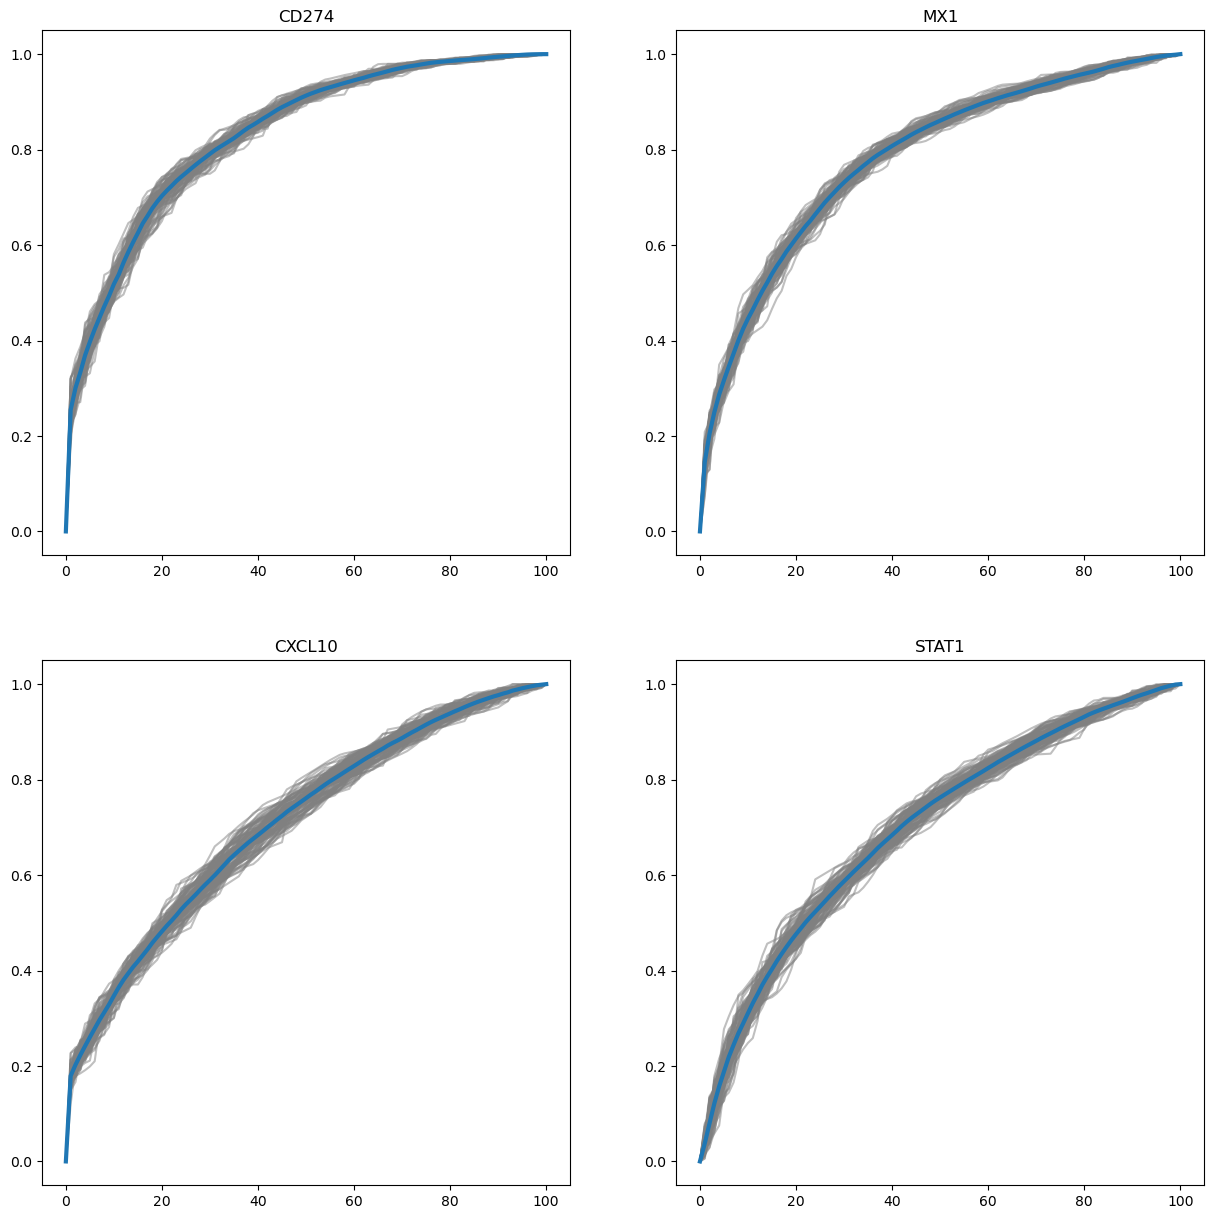

In [85]:
plt.figure(figsize=(15,15))
ax1 = plt.subplot(2,2,1)

for i in range(len(tprs_pdl1)):
    ax1.plot(tprs_pdl1[i], label=i, color = 'grey', alpha=0.5)

ax1.plot(np.mean(tprs_pdl1, axis=0), lw=3)
ax1.set_title('CD274')

ax2 = plt.subplot(2,2,2)

for i in range(len(tprs_mx1)):
    ax2.plot(tprs_mx1[i], label=i, color = 'grey', alpha=0.5)

ax2.plot(np.mean(tprs_mx1, axis=0), lw=3)
ax2.set_title('MX1')

ax3 = plt.subplot(2,2,3)

for i in range(len(tprs_cxcl)):
    ax3.plot(tprs_cxcl[i], label=i, color = 'grey', alpha=0.5)

ax3.plot(np.mean(tprs_cxcl, axis=0), lw=3)
ax3.set_title('CXCL10')

ax4 = plt.subplot(2,2,4)

for i in range(len(tprs_stat)):
    ax4.plot(tprs_stat[i], label=i, color = 'grey', alpha=0.5)

ax4.plot(np.mean(tprs_stat, axis=0), lw=3)
ax4.set_title('STAT1')

In [86]:
output_path = 'E:/OneDrive - Indiana University/jing research/diabetes/PDL MX1/manuscript/figures/figure_data'

In [87]:
condition = '3v7'
np.savez(join(output_path, 'RF_results_20240328_' + condition + '.npz'),
         cms_pdl1=cms_pdl1, ranking_pdl1=ranking_pdl1, tprs_pdl1=tprs_pdl1,
         cms_mx1=cms_mx1, ranking_mx1=ranking_mx1, tprs_mx1=tprs_mx1,
         cms_cxcl=cms_cxcl, ranking_cxcl=ranking_cxcl, tprs_cxcl=tprs_cxcl,
         cms_stat=cms_stat, ranking_stat=ranking_stat, tprs_stat=tprs_stat)

### UMAP

In [81]:
# beta_cells_pdl1_veh = pd.concat([beta_cells_veh_3d_pdl1, beta_cells_veh_14d_pdl1])
# beta_cells_mx1_veh  = pd.concat([beta_cells_veh_3d_mx1, beta_cells_veh_14d_mx1])
# beta_cells_cxcl_veh = pd.concat([beta_cells_veh_3d_cxcl, beta_cells_veh_14d_cxcl])
# beta_cells_stat_veh = pd.concat([beta_cells_veh_3d_stat, beta_cells_veh_14d_stat])

# beta_cells_pdl1_veh = pd.concat([beta_cells_veh_7d_pdl1, beta_cells_veh_14d_pdl1])
# beta_cells_mx1_veh  = pd.concat([beta_cells_veh_7d_mx1, beta_cells_veh_14d_mx1])
# beta_cells_cxcl_veh = pd.concat([beta_cells_veh_7d_cxcl, beta_cells_veh_14d_cxcl])
# beta_cells_stat_veh = pd.concat([beta_cells_veh_7d_stat, beta_cells_veh_14d_stat])

beta_cells_pdl1_veh = pd.concat([beta_cells_veh_3d_pdl1, beta_cells_veh_7d_pdl1])
beta_cells_mx1_veh  = pd.concat([beta_cells_veh_3d_mx1, beta_cells_veh_7d_mx1])
beta_cells_cxcl_veh = pd.concat([beta_cells_veh_3d_cxcl, beta_cells_veh_7d_cxcl])
beta_cells_stat_veh = pd.concat([beta_cells_veh_3d_stat, beta_cells_veh_7d_stat])

# beta_cells_pdl1_veh = beta_cells_veh_3d_pdl1
# beta_cells_mx1_veh  = beta_cells_veh_3d_mx1
# beta_cells_cxcl_veh = beta_cells_veh_3d_cxcl
# beta_cells_stat_veh = beta_cells_veh_3d_stat

# beta_cells_pdl1_veh = beta_cells_veh_7d_pdl1
# beta_cells_mx1_veh  = beta_cells_veh_7d_mx1
# beta_cells_cxcl_veh = beta_cells_veh_7d_cxcl
# beta_cells_stat_veh = beta_cells_veh_7d_stat

# beta_cells_pdl1_veh = beta_cells_veh_14d_pdl1
# beta_cells_mx1_veh  = beta_cells_veh_14d_mx1
# beta_cells_cxcl_veh = beta_cells_veh_14d_cxcl
# beta_cells_stat_veh = beta_cells_veh_14d_stat

In [82]:
feature_array_pdl1 = StandardScaler().fit_transform(np.array(beta_cells_pdl1_veh.drop(columns=['img_file', 'cell', 'days', 'case', 'gene']).dropna()))
label_pdl1_days = np.array(beta_cells_pdl1_veh.dropna()['days'], dtype=int)
le_pdl1_case = LabelEncoder()
le_pdl1_case.fit(beta_cells_pdl1_veh['case'])
label_pdl1_case = le_pdl1_case.transform(beta_cells_pdl1_veh['case'])

feature_array_mx1 = StandardScaler().fit_transform(np.array(beta_cells_mx1_veh.drop(columns=['img_file', 'cell', 'days', 'case', 'gene']).dropna()))
label_mx1_days = np.array(beta_cells_mx1_veh.dropna()['days'], dtype=int)
le_mx1_case = LabelEncoder()
le_mx1_case.fit(beta_cells_mx1_veh['case'])
label_mx1_case = le_mx1_case.transform(beta_cells_mx1_veh['case'])

feature_array_cxcl = StandardScaler().fit_transform(np.array(beta_cells_cxcl_veh.drop(columns=['img_file', 'cell', 'days', 'case', 'gene']).dropna()))
label_cxcl_days = np.array(beta_cells_cxcl_veh.dropna()['days'], dtype=int)
le_cxcl_case = LabelEncoder()
le_cxcl_case.fit(beta_cells_cxcl_veh['case'])
label_cxcl_case = le_cxcl_case.transform(beta_cells_cxcl_veh['case'])

feature_array_stat = StandardScaler().fit_transform(np.array(beta_cells_stat_veh.drop(columns=['img_file', 'cell', 'days', 'case', 'gene']).dropna()))
label_stat_days = np.array(beta_cells_stat_veh.dropna()['days'], dtype=int)
le_stat_case = LabelEncoder()
le_stat_case.fit(beta_cells_stat_veh['case'])
label_stat_case = le_stat_case.transform(beta_cells_stat_veh['case'])

In [83]:
import umap

In [84]:
re_pdl1 = umap.UMAP()
re_mx1  = umap.UMAP()
re_cxcl = umap.UMAP()
re_stat = umap.UMAP()

In [85]:
umap_pdl1 = re_pdl1.fit_transform(StandardScaler().fit_transform(beta_cells_pdl1_veh.drop(columns=['img_file', 'cell', 'days', 'case', 'gene'])))
umap_mx1 = re_mx1.fit_transform(StandardScaler().fit_transform(beta_cells_mx1_veh.drop(columns=['img_file', 'cell', 'days', 'case', 'gene'])))
umap_cxcl = re_cxcl.fit_transform(StandardScaler().fit_transform(beta_cells_cxcl_veh.drop(columns=['img_file', 'cell', 'days', 'case', 'gene'])))
umap_stat = re_stat.fit_transform(StandardScaler().fit_transform(beta_cells_stat_veh.drop(columns=['img_file', 'cell', 'days', 'case', 'gene'])))

<Axes: title={'center': 'STAT1'}>

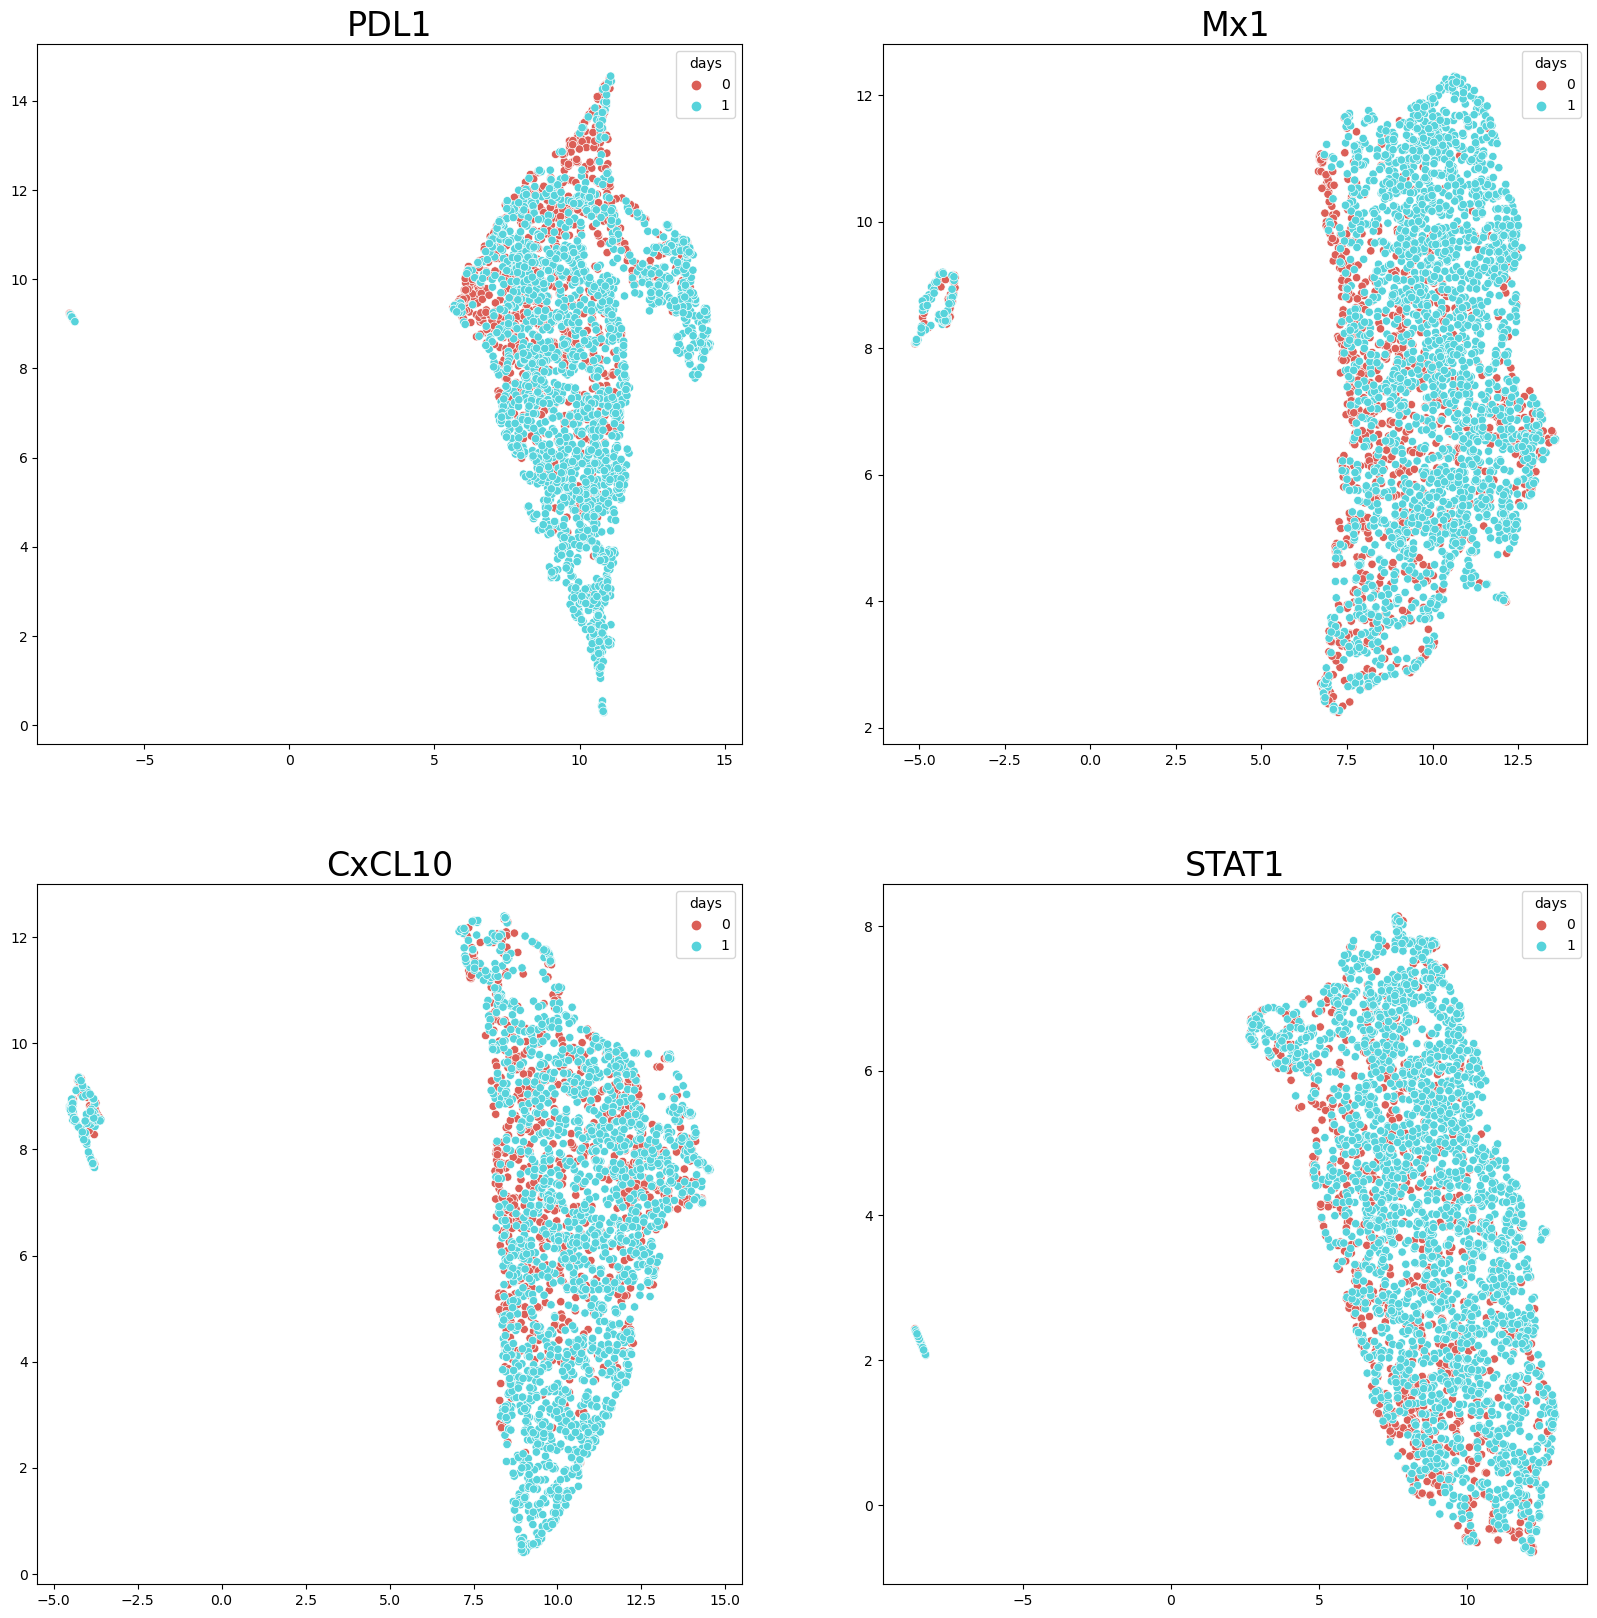

In [86]:
plt.figure(figsize=(20,20))
ax1 = plt.subplot(2,2,1)
ax1.set_title('PDL1', fontsize=24)
sns.scatterplot(x=umap_pdl1[:,0], y=umap_pdl1[:,1],
    hue="days",
    # hue_order=[1,0,2],
    palette=sns.color_palette("hls", 2),
    # style='case',
    data=beta_cells_pdl1_veh.dropna(),
    # legend="full",
    # alpha=feature_pdl1_scaled * (1-0.1) + 0.1,
    # size=feature_pdl1_scaled * (20-1) + 1,
    ax = ax1)

ax2 = plt.subplot(2,2,2)
ax2.set_title('Mx1', fontsize=24)
sns.scatterplot(x=umap_mx1[:,0], y=umap_mx1[:,1],
    hue="days",
    # hue_order=[1,0,2],
    palette=sns.color_palette("hls", 2),
    # style='case',
    data=beta_cells_mx1_veh.dropna(),
    # legend="full",
    # alpha=feature_mx1_scaled * (1-0.1) + 0.1,
    # size=feature_mx1_scaled * (20-1) + 1,
    ax = ax2)

ax3 = plt.subplot(2,2,3)
ax3.set_title('CxCL10', fontsize=24)
sns.scatterplot(x=umap_cxcl[:,0], y=umap_cxcl[:,1],
    hue="days",
    # hue_order=[1,0,2],
    palette=sns.color_palette("hls", 2),
    # style='case',
    data=beta_cells_cxcl_veh.dropna(),
    # legend="full",
    # alpha=feature_cxcl_scaled * (1-0.1) + 0.1,
    # size=feature_cxcl_scaled * (20-1) + 1,
    ax = ax3)

ax4 = plt.subplot(2,2,4)
ax4.set_title('STAT1', fontsize=24)
sns.scatterplot(x=umap_stat[:,0], y=umap_stat[:,1],
    hue="days",
    # hue_order=[1,0,2],
    palette=sns.color_palette("hls", 2),
    # style='case',
    data=beta_cells_stat_veh.dropna(),
    # legend="full",
    # alpha=feature_stat_scaled * (1-0.1) + 0.1,
    # size=feature_stat_scaled * (20-1) + 1,
    ax = ax4)

### Two RNA classification

In [87]:
beta_cells_pdl1_mx1_veh = pd.concat([beta_cells_veh_3d_pdl1,  beta_cells_veh_3d_mx1,
                                     beta_cells_veh_14d_pdl1, beta_cells_veh_14d_mx1])
beta_cells_cxcl_stat_veh = pd.concat([beta_cells_veh_3d_cxcl,  beta_cells_veh_3d_stat,
                                     beta_cells_veh_14d_cxcl, beta_cells_veh_14d_stat])

In [88]:
feature_array_pdl1_mx1 = StandardScaler().fit_transform(np.array(beta_cells_pdl1_mx1_veh.drop(columns=['img_file', 'cell', 'days', 'case', 'gene']).dropna()))
label_pdl1_mx1_days = np.array(beta_cells_pdl1_mx1_veh.dropna()['days'], dtype=int)
le_pdl1_mx1_case = LabelEncoder()
le_pdl1_mx1_case.fit(beta_cells_pdl1_mx1_veh['case'])
label_pdl1_mx1_case = le_pdl1_mx1_case.transform(beta_cells_pdl1_mx1_veh['case'])

feature_array_cxcl_stat = StandardScaler().fit_transform(np.array(beta_cells_cxcl_stat_veh.drop(columns=['img_file', 'cell', 'days', 'case', 'gene']).dropna()))
label_cxcl_stat_days = np.array(beta_cells_cxcl_stat_veh.dropna()['days'], dtype=int)
le_cxcl_stat_case = LabelEncoder()
le_cxcl_stat_case.fit(beta_cells_cxcl_stat_veh['case'])
label_cxcl_stat_case = le_cxcl_stat_case.transform(beta_cells_cxcl_stat_veh['case'])

In [94]:
num = 100
# cms_pdl1_mx1 = np.zeros((num,3,3))
cms_pdl1_mx1 = np.zeros((num,2,2))
accuracies_pdl1_mx1 = np.zeros(num)
ranking_pdl1_mx1 = np.zeros(feature_array_pdl1_mx1.shape[1])
ranking_perm_pdl1_mx1 = np.zeros(feature_array_pdl1_mx1.shape[1])
brier_scores = np.zeros(num)
base_fpr = np.linspace(0,1,101)
tprs_pdl1_mx1 = np.zeros((num, base_fpr.shape[0]))

for i in tqdm(range(num)):

    train_features, test_features, train_labels, test_labels = train_test_split(feature_array_pdl1_mx1, label_pdl1_mx1_days, test_size=0.2, random_state=42)
    
    ibrf = BalancedRandomForestClassifier(sampling_strategy='auto', replacement=True)
    # ibrf = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',random_state=0)
    # ibrf = ensemble.RandomForestClassifier(n_estimators=100)
    ibrf.fit(train_features, train_labels)

    # ibrf_sigmoid = CalibratedClassifierCV(ibrf, method='sigmoid')
    # ibrf_sigmoid.fit(train_features, train_labels)

    accuracies_pdl1_mx1[i] = ibrf.score(test_features, test_labels)

    predictions = ibrf.predict(test_features)
    predictions_proba = ibrf.predict_proba(test_features)
    cm = confusion_matrix(test_labels, predictions, labels=ibrf.classes_, normalize='true')
    cms_pdl1_mx1[i] = cm.T
    # brier_scores[i] = metrics.brier_score_loss(test_labels, predictions_proba[:,1], pos_label=1)
    fpr, tpr, _ = roc_curve(np.array(test_labels), np.array(predictions_proba)[:,1], pos_label=2)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_pdl1_mx1[i] = tpr
    
    importances = list(ibrf.feature_importances_)
    ranking_pdl1_mx1 += importances

    importances_perm = permutation_importance(ibrf, train_features, train_labels, n_jobs=6)
    ranking_perm_pdl1_mx1 += importances_perm.importances_mean

print(np.unique(label_pdl1_mx1_days, return_counts=True))
print(np.mean(cms_pdl1_mx1, axis=0))

100%|██████████| 100/100 [08:13<00:00,  4.94s/it]

(array([0, 2]), array([2083,  484], dtype=int64))
[[0.85866505 0.17117647]
 [0.14133495 0.82882353]]


In [93]:
num = 100
# cms_cxcl_stat = np.zeros((num,3,3))
cms_cxcl_stat = np.zeros((num,2,2))
accuracies_cxcl_stat = np.zeros(num)
ranking_cxcl_stat = np.zeros(feature_array_cxcl_stat.shape[1])
ranking_perm_cxcl_stat = np.zeros(feature_array_cxcl_stat.shape[1])
brier_scores = np.zeros(num)
base_fpr = np.linspace(0,1,101)
tprs_cxcl_stat = np.zeros((num, base_fpr.shape[0]))

for i in tqdm(range(num)):

    train_features, test_features, train_labels, test_labels = train_test_split(feature_array_cxcl_stat, label_cxcl_stat_days, test_size=0.2, random_state=42)
    
    ibrf = BalancedRandomForestClassifier(sampling_strategy='auto', replacement=True)
    # ibrf = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',random_state=0)
    # ibrf = ensemble.RandomForestClassifier(n_estimators=100)
    ibrf.fit(train_features, train_labels)

    # ibrf_sigmoid = CalibratedClassifierCV(ibrf, method='sigmoid')
    # ibrf_sigmoid.fit(train_features, train_labels)

    accuracies_cxcl_stat[i] = ibrf.score(test_features, test_labels)

    predictions = ibrf.predict(test_features)
    predictions_proba = ibrf.predict_proba(test_features)
    cm = confusion_matrix(test_labels, predictions, labels=ibrf.classes_, normalize='true')
    cms_cxcl_stat[i] = cm.T
    # brier_scores[i] = metrics.brier_score_loss(test_labels, predictions_proba[:,1], pos_label=1)
    fpr, tpr, _ = roc_curve(np.array(test_labels), np.array(predictions_proba)[:,1], pos_label=2)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_cxcl_stat[i] = tpr
    
    importances = list(ibrf.feature_importances_)
    ranking_cxcl_stat += importances

    importances_perm = permutation_importance(ibrf, train_features, train_labels, n_jobs=6)
    ranking_perm_cxcl_stat += importances_perm.importances_mean

print(np.unique(label_cxcl_stat_days, return_counts=True))
print(np.mean(cms_cxcl_stat, axis=0))

100%|██████████| 100/100 [15:12<00:00,  9.13s/it]

(array([0, 2]), array([1964, 1420], dtype=int64))
[[0.65455    0.13801444]
 [0.34545    0.86198556]]


In [95]:
tprs_rf = np.load('E:/OneDrive - Indiana University/jing research/diabetes/PDL MX1/manuscript/figures/figure_data/RF_results_20240328_3v14.npz')

In [98]:
x = np.linspace(0,1,101)

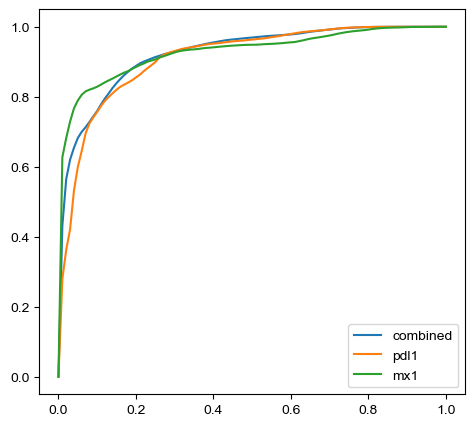

In [107]:
plt.figure(figsize=(5.5,5))

plt.plot(x, np.mean(tprs_pdl1_mx1, axis=0), label='combined')
plt.plot(x, np.mean(tprs_rf['tprs_pdl1'], axis=0), label='pdl1')
plt.plot(x, np.mean(tprs_rf['tprs_mx1'], axis=0), label='mx1')

plt.legend()

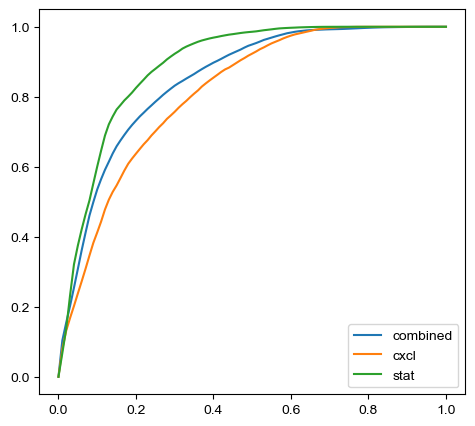

In [108]:
plt.figure(figsize=(5.5,5))

plt.plot(x, np.mean(tprs_cxcl_stat, axis=0), label='combined')
plt.plot(x, np.mean(tprs_rf['tprs_cxcl'], axis=0), label='cxcl')
plt.plot(x, np.mean(tprs_rf['tprs_stat'], axis=0), label='stat')

plt.legend()